NMT (seq2seq) in fastai v1

Start with this:<br>
https://gist.github.com/ohmeow/fe91aed6267cd779946ab9f10eccdab9

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

In [3]:
!pwd

/home/farzin/haha_2019


In [4]:
!ls ./data/es-en

en_es_translate.csv  es-en.tgz	europarl-v7.es-en.en  europarl-v7.es-en.es


In [5]:
DATA_PATH = Path('./data/es-en')

BASE = 'europarl-v7.es-en'
en_file = DATA_PATH/f'{BASE}.en'
es_file = DATA_PATH/f'{BASE}.es'

In [6]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_sq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq), re_sq.search(sq)) 
          for eq, sq in zip(open(en_file, encoding='utf-8'), open(es_file, encoding='utf-8')))

qs = [ {'english_text': e.group(), 'spanish_text': f.group()} for e, f in lines if e and f ]

In [7]:
qs[:5]

[{'english_text': 'Why has no air quality test been done on this particular building since we were elected?',
  'spanish_text': '¿Por qué no se ha hecho ninguna prueba de calidad del aire de este edificio desde que hemos sido elegidos?'},
 {'english_text': 'Why has there been no Health and Safety Committee meeting since 1998?',
  'spanish_text': '¿Por qué no se ha celebrado ninguna reunión del Comité de Sanidad y Seguridad desde 1998?'},
 {'english_text': 'Why has there been no fire drill, either in the Brussels Parliament buildings or the Strasbourg Parliament buildings?',
  'spanish_text': '¿Por qué no hemos tenido simulacros de incendio ni en los edificios del Parlamento de Bruselas ni en los del Parlamento de Estrasburgo?'},
 {'english_text': 'Why are there no fire instructions?',
  'spanish_text': '¿Por qué no hay instrucciones en caso de incendio?'},
 {'english_text': 'Why have the staircases not been improved since my accident?',
  'spanish_text': '¿Por qué no se han mejorado la

In [8]:
df = pd.DataFrame(qs)
df.head()

,english_text,spanish_text
0,Why has no air quality test been done on this ...,¿Por qué no se ha hecho ninguna prueba de cali...
1,Why has there been no Health and Safety Commit...,¿Por qué no se ha celebrado ninguna reunión de...
2,"Why has there been no fire drill, either in th...",¿Por qué no hemos tenido simulacros de incendi...
3,Why are there no fire instructions?,¿Por qué no hay instrucciones en caso de incen...
4,Why have the staircases not been improved sinc...,¿Por qué no se han mejorado las escaleras desd...


In [9]:
df.to_csv(DATA_PATH/'en_es_translate.csv', index=False)

# Load data, split, build DataBunch

In [10]:
df = pd.read_csv(DATA_PATH/'en_es_translate.csv')

rnd_seed = 20190313
np.random.seed(rnd_seed)

idx = np.random.permutation(len(df))
valid_cut = int(0.20 * len(idx))

train_df = df.iloc[idx[:-valid_cut],:]
valid_df = df.iloc[idx[-valid_cut:],:]
train_df.shape, valid_df.shape

((11813, 2), (2953, 2))

In [11]:
def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    x_max_len = max([len(s[0]) for s in samples])
    y_max_len = max([len(s[1]) for s in samples])
    
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    return x_res, y_res

In [12]:
class Seq2SeqDataBunch(DataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:        
        """Function that transform the `datasets` in a `DataBunch` for classification.  Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [13]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch

In [14]:
en_tok = Tokenizer(lang='en')
es_tok = Tokenizer(lang='es')

en_procs = [TokenizeProcessor(tokenizer=en_tok), NumericalizeProcessor()]
es_procs = [TokenizeProcessor(tokenizer=es_tok), NumericalizeProcessor()]

In [15]:
PATH = Path('./data/seq2seq/')
bs = 64

en_train_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['english_text'], processor=en_procs)
es_train_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['spanish_text'], processor=es_procs)

en_valid_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['english_text'])
es_valid_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['spanish_text'])

trn_ll = LabelList(en_train_il, es_train_il)
val_ll = LabelList(en_valid_il, es_valid_il)

lls = LabelLists(PATH, train=trn_ll, valid=val_ll).process()

data = lls.databunch(bs=bs, val_bs=bs)

In [16]:
len(en_train_il.vocab.itos), len(es_train_il.vocab.itos)

(4052, 4658)

In [17]:
b = next(iter(data.train_dl))
b[0].shape, b[1].shape

(torch.Size([64, 155]), torch.Size([64, 147]))

In [18]:
b[0]

tensor([[   2,    5,   11,  ...,    5, 1338,   10],
        [   2,    5,   11,  ...,    1,    1,    1],
        [   2,    5,   36,  ...,    1,    1,    1],
        ...,
        [   2,    5,   36,  ...,    1,    1,    1],
        [   2,    5,   36,  ...,    1,    1,    1],
        [   2,    5,   18,  ...,    1,    1,    1]], device='cuda:0')

In [19]:
b[1]

tensor([[   2,   10,    5,  ..., 1791, 3303,    9],
        [   2,   10,    5,  ...,    1,    1,    1],
        [   2,    5,   56,  ...,    1,    1,    1],
        ...,
        [   2,   10,    5,  ...,    1,    1,    1],
        [   2,    5,   56,  ...,    1,    1,    1],
        [   2,   10,    5,  ...,    1,    1,    1]], device='cuda:0')

In [20]:
len(data.label_list.train.x.vocab.itos), len(data.label_list.train.y.vocab.itos)

(4052, 4658)

In [21]:
len(data.label_list.train.x.vocab.itos), data.label_list.train.vocab.itos[:20]

(4052,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  '?',
  'what',
  'to',
  ',',
  'of',
  'is',
  'in',
  'and',
  'why',
  'we'])

In [22]:
type(data)

__main__.Seq2SeqDataBunch

# Build a model for Seq2Seq

Big help from this link from the old course + looking at the `Transformer` code and adapting <br>
https://github.com/kheyer/ML-DL-Projects/blob/master/Seq2Seq%20Transformer/Transformer.ipynb


## Build Seq2SeqTransformer

In [23]:
class m_MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.att_q = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_k = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.att_v = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None, **kwargs):
        "attn -> Linear -> drop -> merge -> LN"
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask, **kwargs))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,x_len = q.size(0),q.size(1) # bs x bptt x d_model
        wq,wk,wv = self.att_q(q), self.att_k(k), self.att_v(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, x_len, -1)

In [24]:
_activ_func = {Activation.ReLU:nn.ReLU(inplace=True), Activation.GeLU:GeLU(), Activation.Swish: Swish}
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., act:Activation=Activation.ReLU, double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), _activ_func[act]]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

class m_EncoderLayer(nn.Module):
    "Basic block of a Transformer model."
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, act:Activation=Activation.ReLU, double_drop:bool=True,
                 attn_cls:Callable=m_MultiHeadAttention):
        super().__init__()
        self.mhra = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)
    
    def forward(self, x:Tensor, mask:Tensor=None, **kwargs): return self.ff(self.mhra(x, x, x, mask=mask, **kwargs))

class m_DecoderLayer(nn.Module):
    "Decoder block for seq2seq. Self and target attention combined."
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, act:Activation=Activation.ReLU, double_drop:bool=True,
                 attn_cls:Callable=m_MultiHeadAttention):
        super().__init__()
        self.mhra_s    = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.mhra_targ = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)
        
    def forward(self, x:Tensor, enc_out:Tensor, src_mask:Tensor=None, targ_mask:Tensor=None, **kwargs): 
        x = self.mhra_s(x,x,x, mask=targ_mask, **kwargs)
        return self.ff(self.mhra_targ(x, enc_out, enc_out, mask=src_mask, **kwargs))
    
class Seq2SeqTransformer(nn.Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, vocab_sz:int, tgt_vocab_sz:int, ctx_len:int, n_layers:int, n_heads:int, d_model:int, d_head:int, 
                 d_inner:int, 
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=True, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=m_MultiHeadAttention,
                 learned_pos_enc:bool=True, mask:bool=True):
        super().__init__()
        self.mask = mask
        self.encoder = nn.Embedding(vocab_sz, d_model)
        self.pos_enc = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_emb = nn.Dropout(embed_p)

        self.enc_layers = nn.ModuleList([m_EncoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                          ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                          attn_cls=attn_cls) for k in range(n_layers)])

        self.decoder = nn.Embedding(tgt_vocab_sz, d_model)
        self.pos_dec = nn.Embedding(ctx_len, d_model) if learned_pos_enc else PositionalEncoding(d_model)
        self.drop_dec = nn.Dropout(embed_p)

        self.dec_layers = nn.ModuleList([m_DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                          ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
                          attn_cls=attn_cls) for k in range(n_layers)])
        
        self.tgt_word_prj = nn.Linear(d_model, tgt_vocab_sz, bias=False)
        nn.init.xavier_normal_(self.tgt_word_prj.weight)
        self.x_logit_scale = (d_model ** -0.5)
        
    def reset(self):pass
        
    def forward(self, x, y):
        bs, x_len = x.size()
        bs, y_len = y.size()
        pos = torch.arange(0, x_len, device=x.device, dtype=x.dtype)
        inp = self.drop_emb(self.encoder(x) + self.pos_enc(pos)[None]) #.mul_(self.d_model ** 0.5)
        pos_y = torch.arange(0, y_len, device=x.device, dtype=x.dtype)
        targ = self.drop_dec(self.decoder(y) + self.pos_dec(pos_y)[None]) #.mul_(self.d_model ** 0.5)

        ## masking/padding is not yet right here.  Needs to be fixed to mask the pad IDs
        src_mask = (x==1).byte()[:,None,None,:] #[64,5,155,155]
        #mask == trg_mask (but trg_mask also masks out all xxpad ids [id==1]  add that here)
        nopeak_mask = torch.triu(x.new_ones(y_len, y_len), diagonal=1).byte() if self.mask else None
        targ_mask = (y==1).byte()[:,None,:,None] * nopeak_mask
        
        for layer in self.enc_layers: inp  = layer(inp, mask=src_mask)
        for layer in self.dec_layers: targ = layer(targ, inp, src_mask=src_mask, targ_mask=targ_mask)
        decoded = self.tgt_word_prj(targ) * self.x_logit_scale

        return [decoded,decoded,decoded] #for RNN trainer

In [40]:
tfm_seq2seq = Seq2SeqTransformer(vocab_sz=len(data.label_list.train.x.vocab.itos),
                       tgt_vocab_sz=len(data.label_list.train.y.vocab.itos),
                       ctx_len=256, n_layers=6, n_heads=5, d_model=768, d_head=64, d_inner=1024)

In [52]:
def init_transformer(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 0., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 1., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)

In [53]:
_ = tfm_seq2seq.apply(init_transformer)

If I add `on_batch_begin` to return x,y as `xb` then that is passed as `*xb` to the model and we can extract y and use for teacher forcing and proper attention?

In [54]:
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

In [55]:
learn = LanguageLearner(data, tfm_seq2seq, **{'alpha':0,'beta':0}, callbacks=[AppendBatchTargs()], loss_func=CrossEntropyFlat())
learn.unfreeze()

In [56]:
total_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
f'{total_params:,}'

'47,327,616'

In [46]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


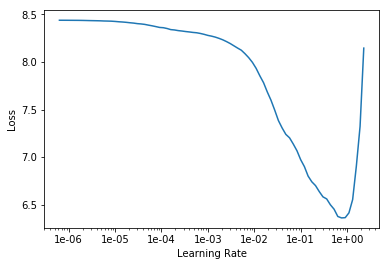

In [48]:
learn.recorder.plot(skip_end=5)

In [ ]:
## fit one cycle is just too darn agressive for Transformer. Why?
learn.fit(25, lr=3e-4)

epoch,train_loss,valid_loss,time
0,6.225850,5.730264,00:35
1,3.681012,3.360382,00:36
2,2.101718,2.061979,00:35
3,1.328639,1.381029,00:36
4,0.924974,0.974917,00:34


In [ ]:
learn.recorder.plot_losses()

In [51]:
x,y = next(iter(learn.data.train_dl))

src = x[0,:]
targ = y[0,:]

preds = learn.model(src.unsqueeze(0), targ.unsqueeze(0))
preds[0].argmax(dim=-1)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')

In [171]:
  ## all predicting padding! haha.  something not right here.

tensor([[5, 5, 5, 5, 5, 5, 5, 9, 9, 5, 5, 9, 5, 9, 5, 5, 9, 5, 5, 1, 5, 5, 5, 5,
         9, 9, 9, 9, 9, 5, 9, 5, 9, 5, 9, 9, 5, 5, 5, 5, 9, 1, 9, 9, 1, 5, 5, 1,
         5, 5, 9, 5, 5, 9, 9, 5, 5, 5, 5, 5, 9, 9, 9, 9, 1, 5, 9, 5, 5, 1, 9, 5,
         1, 9, 5, 5, 5, 5, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5, 9, 5, 9, 9, 9, 5, 1, 5,
         5, 9, 5, 9, 5, 5, 5, 5, 5, 9, 1, 1, 5, 5, 1, 5, 9, 9, 9, 9, 5, 5, 9, 5,
         5, 1, 5, 5, 5, 9, 5, 9, 9, 1, 5, 9, 5, 5, 5, 5, 9, 9, 5, 5, 9, 9, 1, 1,
         9, 9, 5]], device='cuda:0')

In [172]:
data.label_list.train.x.vocab.itos[1] ## must be because there are a lot of padding vals in there!

'xxpad'

In [37]:
learn.model

Seq2SeqTransformer(
  (encoder): Embedding(4052, 300)
  (pos_enc): Embedding(256, 300)
  (drop_emb): Dropout(p=0.0)
  (enc_layers): ModuleList(
    (0): m_EncoderLayer(
      (mhra): m_MultiHeadAttention(
        (att_q): Linear(in_features=300, out_features=320, bias=True)
        (att_k): Linear(in_features=300, out_features=320, bias=True)
        (att_v): Linear(in_features=300, out_features=320, bias=True)
        (out): Linear(in_features=320, out_features=300, bias=True)
        (drop_att): Dropout(p=0.0)
        (drop_res): Dropout(p=0.0)
        (ln): LayerNorm(torch.Size([300]), eps=1e-05, elementwise_affine=True)
      )
      (ff): SequentialEx(
        (layers): ModuleList(
          (0): Linear(in_features=300, out_features=128, bias=True)
          (1): ReLU(inplace)
          (2): Dropout(p=0.0)
          (3): Linear(in_features=128, out_features=300, bias=True)
          (4): Dropout(p=0.0)
          (5): MergeLayer()
          (6): LayerNorm(torch.Size([300]), eps=1e-